# Imports

In [243]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
import itertools

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import metrics, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble, model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from wordcloud import WordCloud ,STOPWORDS
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
stop_words= stopwords.words('spanish')

import spacy
nlp = spacy.load('es_core_news_sm')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Data Loading Functions

In [244]:
# train_d_path = "data/en/"
# test_d_path = "../../data/en_test/"
"""
Loading the data   --- these functions are taken and modified from ashraf2019
"""


def iter_docs(author):
    author_attr = author.attrib
    doc_dict = author_attr.copy()
    doc_dict['text'] = [' '.join([doc.text for doc in author.iter('document')])]
    return doc_dict


def create_test_data_frame(input_folder):
    # os.chdir(input_folder)
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    truth_data = pd.read_csv('truth.txt', sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)

    data = text_Data.merge(truth_data, on='author_id')
    return data


def create_training_data_frame(input_folder, taining_div, testing_div):
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    train_truth_div_data = pd.read_csv(taining_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    test_truth_div_data = pd.read_csv(testing_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)
    training_data = text_Data.merge(train_truth_div_data, on='author_id')
    testing_data = text_Data.merge(test_truth_div_data, on='author_id')
    return training_data, testing_data

# Step 1  - Training Data split and exploration

In [245]:
# change the paths according to your system
es_training_div_data, es_testing_div_data = create_training_data_frame(
                                            r"C:\Users\loren\Dropbox\Estudios\Universidad\Uni Tübingen\ISCL\Asignaturas\1. Semester\Author Profiling\Project\pan\pan19-author-profiling-training-dataset-2019-02-18\es", 
                                            'truth-train.txt', 'truth-dev.txt')
                                            

In [246]:
print("English training data split size", len(es_training_div_data))
print("English testing data split size", len(es_testing_div_data))

English training data split size 2080
English testing data split size 920


In [247]:
es_training_div_data.head()  # how the training data looks like

,lang,text,author_id,author,gender
0,es,#es La magia de Mijaíl Tal - Es poco menos que...,103c43bf5a2b2bcafa37c5743c752a77,bot,bot
1,es,"Jajajajajajajajaja mi alma, el único que no ex...",10476fa092546c94baf0af18f2b9c846,human,female
2,es,@cutomunoz si las vi ayer!! Pero ahí lo dan po...,1064aa2dc732f7311936c5355e4d7494,human,female
3,es,naranja como el sentir de unos traseros comput...,10829e0fc12d96d933233fb6fa715648,bot,bot
4,es,RT @alvarosalazaro: @alFranceschi Ni los lider...,10919a911b053422c944a1e0313efe3d,human,male


In [248]:
es_training_div_data['author'].unique()  # there are only two values in author

array(['bot', 'human'], dtype=object)

In [249]:
es_training_div_data.shape  # 2880 enties with 5 columns

(2080, 5)

In [250]:
es_training_div_data.isnull().any()   # none of the columns has empty entries

lang         False
text         False
author_id    False
author       False
gender       False
dtype: bool

C:\Users\loren\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='author', ylabel='count'>

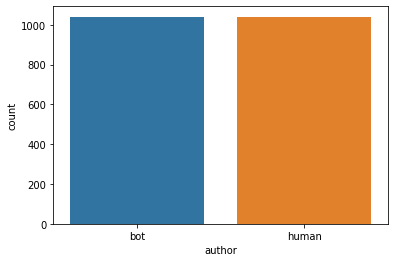

In [251]:
sns.countplot(es_training_div_data.author)   # data distribution is exactly even

C:\Users\loren\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

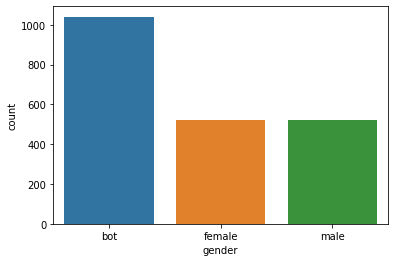

In [252]:
sns.countplot(es_training_div_data.gender)  # in gender: bot is twice the size of male/female

In [253]:
es_training_div_data['tweet_length'] = es_training_div_data['text'].str.len()
print(es_training_div_data['tweet_length'])    

0       11833
1        9197
2        6070
3       11691
4       13683
        ...  
2075     9877
2076     9783
2077    11835
2078     7549
2079     8020
Name: tweet_length, Length: 2080, dtype: int64


C:\Users\loren\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


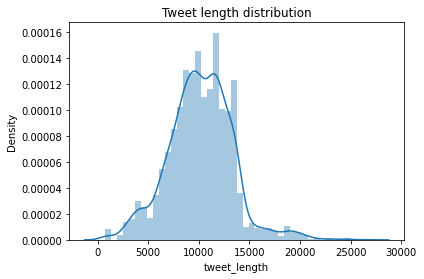

In [254]:
sns.distplot(es_training_div_data['tweet_length']).set_title('Tweet length distribution');  
# most tweet bodies are between 5000 and 15000 chars

# Wordclouds

In [255]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

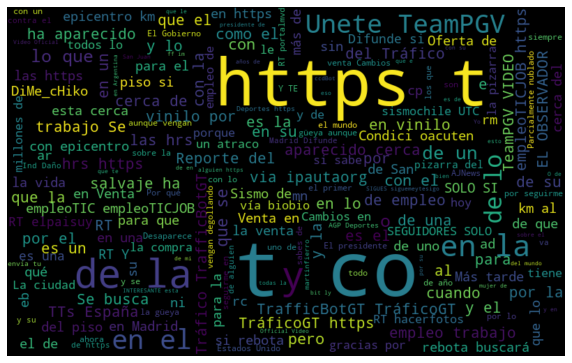

In [256]:
subset=es_training_div_data[es_training_div_data.author=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in author/bot

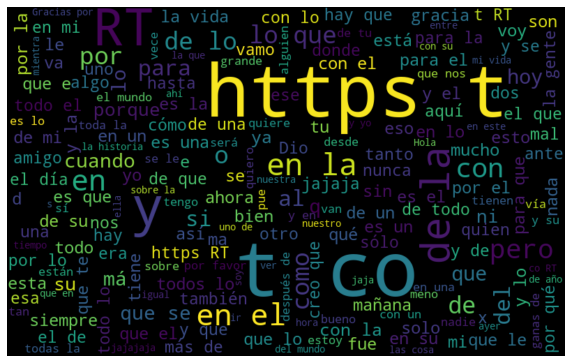

In [257]:
subset=es_training_div_data[es_training_div_data.author=="human"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in author/human

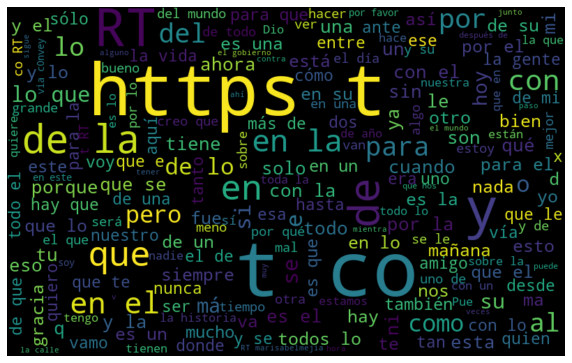

In [258]:
subset=es_training_div_data[es_training_div_data.gender=="male"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/male

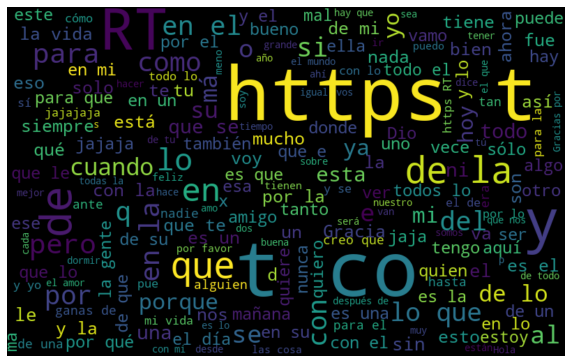

In [259]:
subset=es_training_div_data[es_training_div_data.gender=="female"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/female

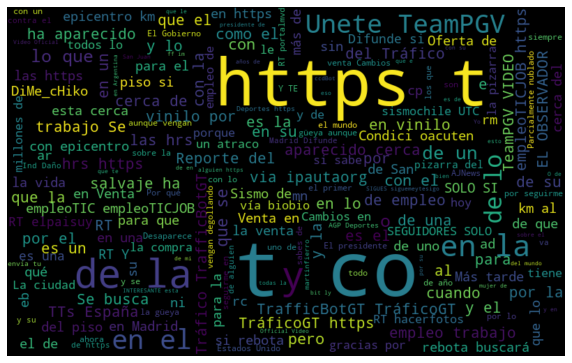

In [260]:
subset=es_training_div_data[es_training_div_data.gender=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/bot

# Step 2 - Preprocessing and finding the most common words across the corpus 

In [261]:
# gensim only accepts tokenized lists
# so this preprocesses and coverts tweet-body strings into tokens
# to do: we could use nltk.TweetTokenizer and see what happens. 
# to do: we could try different lemmatization libraries
def build_tokenized_corpus(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()
        # Extra layers Lorena
        tweet = re.sub(r'https?:\/\/.\S*', 'URL', tweet)  # replace every url for a custom word
        tweet = re.sub(r'@.\S*', 'MENTION', tweet)  # replace every mention for a custom word
        tweet = re.sub(r'#.\S*', 'HASHTAG', tweet)  # replace every hashtag for a custom word
#        tweet = re.sub(r'".*"', 'QUOTE', tweet)  # replace every quote for a custom word
#         tweet = re.sub(r'@.\S*', '', tweet)  # removes every mention
#         tweet = re.sub(r'#.\S*', '', tweet)  # removes every hashtag
#         tweet = re.sub(r'".*"', '', tweet)  # removes every quote
        # tweet = re.sub(r'\W', ' ', tweet)  # remove non-w chars
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove our extra spaces

        # lemmatize words
        #tweet = word_tokenize(tweet)
        #tweet = [w for w in tweet if w not in stop_words]
#         tweet = [stemmer.stem(w) for w in tweet]
        tokenizedTweet = nlp(tweet)
        #sentiment analyzer
        analyser = SentimentIntensityAnalyzer()
        score = analyser.polarity_scores(tweet)
        # convert dictionary into string
        score = str(score) 
        processedTweet = []
        for l in tokenizedTweet:
            processedTweet.append(f"{l.lemma_}({l.pos_})")
        processedTweet.append(score)
        corpus.append(processedTweet)
    return corpus

In [262]:
processed_train_split_corpus = build_tokenized_corpus(es_training_div_data['text'])
processed_test_split_corpus = build_tokenized_corpus(es_testing_div_data['text'])
print("ready")

ready


In [263]:
# this is how the tokenization and preprocessing looks like
# to do: might need dimensionality reduction
df = pd.DataFrame(processed_train_split_corpus)
df

,0,1,2,3,4,5,6,7,8,9,...,4806,4807,4808,4809,4810,4811,4812,4813,4814,4815
0,HASHTAG(PROPN),el(DET),magia(NOUN),de(ADP),mijaíl(NOUN),tal(DET),-(PUNCT),ser(AUX),poco(ADV),menos(ADV),...,None,None,None,None,None,None,None,None,None,None
1,jajajajajajajajajar(VERB),mi(DET),alma(NOUN),",(PUNCT)",el(DET),único(ADJ),que(PRON),no(ADV),existir(VERB),ser(AUX),...,None,None,None,None,None,None,None,None,None,None
2,@cutomunoz(VERB),si(SCONJ),él(PRON),ver(VERB),ayer(ADV),!(PUNCT),!(PUNCT),pero(CCONJ),ahí(ADV),él(PRON),...,None,None,None,None,None,None,None,None,None,None
3,naranjar(VERB),como(SCONJ),el(DET),sentir(NOUN),de(ADP),uno(DET),trasero(NOUN),computar(VERB),en(ADP),el(DET),...,None,None,None,None,None,None,None,None,None,None
4,rt(DET),@alvarosalazaro(NOUN),:(PUNCT),@alfranceschi(NOUN),ni(CCONJ),el(DET),lider(NOUN),de(ADP),el(DET),cuarto(ADJ),...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,por(ADP),este(PRON),no(ADV),él(PRON),poder(AUX),ser(AUX),apolítico(ADJ),URL(PROPN),estar(AUX),uno(DET),...,None,None,None,None,None,None,None,None,None,None
2076,HASHTAG(PROPN),min:18c(PUNCT),max:33c(PROPN),condici&oacutir(VERB),:(PUNCT),fair(NOUN),más(ADV),tarde(ADV),:(PUNCT),tormenta(NOUN),...,None,None,None,None,None,None,None,None,None,None
2077,azul(ADJ),como(SCONJ),el(DET),olor(NOUN),de(ADP),uno(DET),cueva(NOUN),admirar(VERB),uno(DET),conjunto(NOUN),...,None,None,None,None,None,None,None,None,None,None
2078,@sancadillar(VERB),:o(PUNCT),!(PUNCT),posible(ADJ),potro(NOUN),como(SCONJ),dt(NOUN),de(ADP),atla(ADJ),?(PUNCT),...,None,None,None,None,None,None,None,None,None,None


# The process of finding the common words with TFIDF gensim

In [264]:
# gensim dictionary
dictionary = Dictionary(processed_train_split_corpus)

In [265]:
# tweet_body or doc to bag of word
corpus = [dictionary.doc2bow(doc) for doc in processed_train_split_corpus]

In [266]:
unwanted_most_common_words = {}
# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count 
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# find the top 500 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:100]:
    unwanted_most_common_words[dictionary.get(word_id)] = word_count
#     print(dictionary.get(word_id), word_count)
# print(unwanted_most_common)

# We need to keep track of the special tags we created in the preprocessing
# so we just popped them from the 500 list
#unwanted_most_common_words.pop("URL")
#unwanted_most_common_words.pop("MENTION")
#unwanted_most_common_words.pop("HASHTAG")
#unwanted_most_common_words.pop("QUOTE")
#unwanted_most_common_words.pop("rt")
unwanted_most_common_words.pop("URL(PROPN)")
unwanted_most_common_words.pop("MENTION(PROPN)")
unwanted_most_common_words.pop("HASHTAG(PROPN)")
#unwanted_most_common_words.pop("QUOTE(PROPN)")
unwanted_most_common_words.pop("rt(CCONJ)")
print(unwanted_most_common_words)

KeyError: 'MENTION(PROPN)'

In [232]:
# extract only the keys
unwanted= list(unwanted_most_common_words.keys())

In [233]:
# We need to convert the lists of tokens back to tweet_bodies
# while deleting all unwanted tokens

In [234]:
def combine_tokens_into_tweets(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = data[i]
        tweet = ' '.join([w for w in tweet])
        corpus.append(tweet)
    return corpus

def remove_words_from_tweets(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        # tweet = re.sub(r'\W', ' ', str(data[i]))  # remove non-w chars
        tweet = data[i].split()
        tweet = ' '.join([w for w in tweet if w not in unwanted])
        corpus.append(tweet)
    return corpus

In [235]:
combined_training = combine_tokens_into_tweets(processed_train_split_corpus)
combined_testing = combine_tokens_into_tweets(processed_test_split_corpus)
df = pd.DataFrame(combined_training)
df

,0
0,HASHTAG(PROPN) el(DET) magia(NOUN) de(ADP) mij...
1,"jajajajajajajajajar(VERB) mi(DET) alma(NOUN) ,..."
2,mention(VERB) si(SCONJ) él(PRON) ver(VERB) aye...
3,naranjar(VERB) como(SCONJ) el(DET) sentir(NOUN...
4,rt(DET) MENTION(PROPN) MENTION(PROPN) ni(CCONJ...
...,...
2075,por(ADP) este(PRON) no(ADV) él(PRON) poder(AUX...
2076,HASHTAG(PROPN) min:18c(PUNCT) max:33c(PROPN) c...
2077,azul(ADJ) como(SCONJ) el(DET) olor(NOUN) de(AD...
2078,MENTION(PROPN) :o(PROPN) !(PUNCT) posible(ADJ)...


In [236]:
# final processed splits --> ready to for ML
processed_training_corpus=  remove_words_from_tweets(combined_training)
processed_testing_corpus=  remove_words_from_tweets(combined_testing)
df = pd.DataFrame(processed_training_corpus)
df

,0
0,HASHTAG(PROPN) magia(NOUN) mijaíl(NOUN) tal(DE...
1,jajajajajajajajajar(VERB) alma(NOUN) único(ADJ...
2,mention(VERB) ayer(ADV) ahí(ADV) muerto(ADJ) j...
3,naranjar(VERB) sentir(NOUN) trasero(NOUN) comp...
4,MENTION(PROPN) MENTION(PROPN) lider(NOUN) cuar...
...,...
2075,apolítico(ADJ) URL(PROPN) poquillo(NOUN) lejos...
2076,HASHTAG(PROPN) min:18c(PUNCT) max:33c(PROPN) c...
2077,azul(ADJ) olor(NOUN) cueva(NOUN) admirar(VERB)...
2078,MENTION(PROPN) :o(PROPN) posible(ADJ) potro(NO...


In [237]:
# convert human/bot categories to 1/0 and ready for ML
# to do : could use a library to do this
def set_labels(data):
    labels = []
    for j in range(0, len(data)):
        if data[j] == "human":
            clas = 1
        else:
            clas = 0
        labels.append(clas)
    return labels
training_corpus_labels = set_labels(es_training_div_data['author'])
testing_corpus_labels = set_labels(es_testing_div_data['author'])

# Step 3  - Vectorizing using TFIDF and 1-5 grams

In [238]:
# to do: we can tune the hyperparameters of the vectorizer 
# to find the ultimate ngram and max_feature configuration
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,4), max_features=500, stop_words=stop_words)
vectorized_es_training_div_tweets = vectorizer.fit_transform(processed_training_corpus).toarray()
vectorized_es_testing_div_tweets = vectorizer.transform(processed_testing_corpus).toarray()
print("vectorization ready")

vectorization ready


# Step 4 - ML models hyperparameter tuning to find the best models

In [239]:
# parameter dictionary to apply gridsearchCV on and find 
# the best model for the task humna/bot
# given the vectorizer above
# to do: add more combinations
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': ensemble.RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10, 50, 100, 200, 400, 500, 700]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10, 50, 100]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
        }
    }    
}


In [240]:
# manual gridsearchCV
# to do: can be done much better with hyperopt
# english bot/human
evaluation_es_human_bot = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_es_training_div_tweets,training_corpus_labels)
        evaluation_es_human_bot.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_es_human_bot, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.934135,"{'C': 20, 'kernel': 'linear'}"
1,random_forest,0.945192,{'n_estimators': 200}
2,logistic_regression,0.935096,{'C': 100}
3,naive_bayes_gaussian,0.755769,{}
4,naive_bayes_multinomial,0.810096,{}
5,decision_tree,0.911538,{'criterion': 'gini'}


In [241]:
# test area 
# change the hyperparameters of the model and the model according to the chart above
print("Human/Bot: English - testing split test accuracy ")

es_ML_model = SVC(C=20, kernel='linear')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels)
print("SVM:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


es_ML_model = ensemble.RandomForestClassifier(n_estimators= 400)
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels)
print("Random forest:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")

es_ML_model = GaussianNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels)
print("Naive Bayes G:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


es_ML_model = MultinomialNB()
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels)
print("Naive Bayes MN:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


es_ML_model = DecisionTreeClassifier(criterion='gini')
es_ML_model.fit(vectorized_es_training_div_tweets,training_corpus_labels)
print("Decision Tree:" , accuracy_score(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))
print(classification_report(es_ML_model.predict(vectorized_es_testing_div_tweets),testing_corpus_labels))

# logistic regression needs data scaling
# en_ML_model = LogisticRegression(C= 100)
# en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
# print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))


Human/Bot: English - testing split test accuracy 
SVM: 0.8652173913043478
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       380
           1       0.95      0.81      0.88       540

    accuracy                           0.87       920
   macro avg       0.87      0.88      0.86       920
weighted avg       0.88      0.87      0.87       920

-----------------------------------------
Random forest: 0.9152173913043479
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       418
           1       0.96      0.88      0.92       502

    accuracy                           0.92       920
   macro avg       0.92      0.92      0.92       920
weighted avg       0.92      0.92      0.92       920

-----------------------------------------
Naive Bayes G: 0.6978260869565217
              precision    recall  f1-score   support

           0       0.44      0.91      0.59       224
           

In [242]:
"""
NOTES:
1- the preprocessing can be split into es_preprocess and en_preprocess to process each language separately
2- The tuning is showing potential for more accuracy but I cannot figure out how to make the ml model reflect it. 
    for now, the default param scores higher. I wonder how pizzaro 2019 did it.
3- We can add more word clouds to see the change after the removel of 500 words
"""

'\nNOTES:\n1- the preprocessing can be split into es_preprocess and en_preprocess to process each language separately\n2- The tuning is showing potential for more accuracy but I cannot figure out how to make the ml model reflect it. \n    for now, the default param scores higher. I wonder how pizzaro 2019 did it.\n3- We can add more word clouds to see the change after the removel of 500 words\n'